# AI6126 ACV Project 1


In [ ]:
nb_ver = 1.2
title = f'ai6126-project1-colab-v{nb_ver}'
print(title)
comments = ""
print(comments)

## Versioning & References

### Changelogs
+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 
+ V0.3 - Added seeding + save/ load checkpoint
+ V0.4 - Added time taken + save output
+ V0.5 - Added RandomErasing to transforms
+ V0.6 - Added get_criterion (FocalLoss) 
+ V0.7 - Added FaceAttrMobileNetV2 & FaceAttrResNeXt
+ V0.8 - Added Albumentations
+ V0.9 - Updated Optimizer (SGD, AdamW works well)
+ V0.91 - Added ModelTimer() + Added more augmentations
+ V1.0 - Added ReduceLROnPlateau Scheduler
+ V1.1 - Updated Augmentations to more closely follow Tricks paper + Added OneCycleLR Scheduler + No bias decay
+ V1.2 - Added Early Stopping

### ToDo:
+ V1.1 - Train with new Augmentations
+ V1.1 - Train with OneCycleLR 
+ V1.1 - Train with no bias decay 
+ Tune weight decay parameter

### References
+ [Face Attribute Prediction on CelebA benchmark with PyTorch Implementation](https://github.com/d-li14/face-attribute-prediction)
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
+ [Albumentations](https://albumentations.ai/)
+ [Focal Loss](https://github.com/kornia/kornia/blob/master/kornia/losses/focal.py)
+ [Bag of Tricks](https://arxiv.org/abs/1812.01187)

### Dependencies

In [ ]:
# conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
# conda install matplotlib
# conda install pandas
# conda install tqdm
# conda install -c conda-forge jupyterlab
# conda install -c conda-forge tensorboard
# conda install -c conda-forge protobuf # for tensorboard
# conda install nb_conda_kernels # auto add kernels

# conda install -c conda-forge imgaug
# conda install albumentations -c conda-forge

## Setup/ Configuration

### Colab

In [ ]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

### Download Dataset (JUPYTER ONLY)

In [4]:
import os, glob
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

download celeba dataset: False


## Implementation

### Imports

In [5]:
import sys, os
import shutil
import time
import random
import numpy as np
import copy
from datetime import datetime
from distutils.dir_util import copy_tree #for recursive filecopying

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt

import config
from celeba_dataset import CelebaDataset
import models
import losses
from utils import Logger, AverageMeter, Bar, ModelTimer, savefig, adjust_learning_rate, accuracy, reset_gpu_cache, print_attribute_acc, create_dir_ifne, add_weight_decay

In [6]:
# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

ISJUPYTER = False
if 'ipykernel' in sys.modules:
    ISJUPYTER = True
    # set the backend of matplotlib to the 'inline' backend
    %matplotlib inline
    config.disable_tqdm = False
    
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [7]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
def load_dataloaders(print_info=True, albu_transforms = True):
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }

    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        data_transforms = {
            'train': transforms.Compose([
                transforms.CenterCrop(128), #new
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10), #new
                transforms.ToTensor(),
                normalize,
                transforms.RandomErasing()
            ]),
            'val': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ]),
            'test': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ])
        }
    else:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                                  std=(0.229, 0.224, 0.225))
        data_transforms = {
            'train': A.Compose([
                #A.RandomResizedCrop(148, 148), # cuts out too much attributes, use centercrop instead
                A.CenterCrop(height=168, width=168),
                #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                #                  rotate_limit=15, p=0.5), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
                A.HorizontalFlip(p=0.5),
                A.HueSaturationValue(hue_shift_limit=14, sat_shift_limit=14, val_shift_limit=14, p=0.5),
                A.FancyPCA(alpha=0.1, p=0.5), #http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
                A.GaussNoise(var_limit=10.0, p=0.5), 
                A.GaussianBlur(p=0.1), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
                #A.CoarseDropout(max_holes=1, max_height=74, max_width=74, 
                #                min_height=49, min_width=49, fill_value=0, p=0.2), #https://arxiv.org/pdf/1708.04896.pdf
                normalize_A,
                ToTensorV2(),
                
            ]),
            'val': A.Compose([
                #Rescale an image so that minimum side is equal to max_size 178 (shortest edge of Celeba)
                A.SmallestMaxSize(max_size=178), 
                A.CenterCrop(height=168, width=168),
                normalize_A,
                ToTensorV2(),
            ]),
            'test': A.Compose([
                A.SmallestMaxSize(max_size=178),
                A.CenterCrop(height=168, width=168),
                normalize_A,
                ToTensorV2(),
            ])
        }

    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x]) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return dataloaders, attribute_names

### Model Architecture Initialization

In [9]:
model_names = sorted(name for name in models.__dict__
                     if callable(models.__dict__[name])) # and name.islower() and not name.startswith("__"))
print(f"Available Models: {model_names}")

Available Models: ['FaceAttrMobileNetV2', 'FaceAttrResNeXt', 'FaceAttrResNet']


In [10]:
def create_model(device):
    print("=> creating model '{}'".format(config.arch))
    if config.arch.startswith('FaceAttrResNet'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrResNeXt'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrMobileNetV2'):
        model = models.__dict__[config.arch]()
    #print(model)
    model = model.to(device)
    return model
#print(model)
model = create_model(device)

=> creating model 'FaceAttrResNet'


### Criterion & Optimizer & Scheduler

In [11]:
def get_criterion():
    criterion = nn.CrossEntropyLoss().to(device)
    if config.criterion == 'BinaryFocalLoss':
        criterion = losses.BinaryFocalLoss().to(device)
    elif config.criterion == 'FocalLoss':
        criterion = losses.FocalLoss(alpha=0.25, gamma=5, reduction='mean').to(device)
    return criterion

criterion = get_criterion()

In [12]:
def get_optimizer(model, no_bias_bn_decay=True):
    weight_decay = config.weight_decay
    if no_bias_bn_decay: #bag of tricks paper
        parameters = add_weight_decay(model, weight_decay)
        weight_decay = 0.
    else:
        parameters = model.parameters()
        
    optimizer = torch.optim.SGD(parameters, config.lr,
                            momentum=config.momentum,
                            weight_decay=weight_decay)
    if config.optimizer == 'Adam':
        optimizer = torch.optim.Adam(parameters, config.lr,
                            weight_decay=weight_decay)
    elif config.optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(parameters, config.lr,
                            weight_decay=weight_decay)
    return optimizer

optimizer = get_optimizer(model)

In [13]:
def get_scheduler(optimizer, steps_per_epoch, epochs):
    scheduler = None # Manual
    if config.scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                               factor=0.1,
                                                               patience=config.patience)
    elif config.scheduler == 'OneCycleLR': 
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, epochs=epochs,
                                                        steps_per_epoch=int(steps_per_epoch), 
                                                        anneal_strategy='cos') #https://arxiv.org/pdf/1708.07120.pdf
    return scheduler    

### Resume Checkpoint if any

In [14]:
def resume_checkpoint(model, optimizer, ckp_logger_fname, ckp_resume=None):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise
            
    start_epoch = 0
    best_prec1 = 0
    lr = config.lr

    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        optimizer, start_epoch, best_prec1, lr, total_train_time = model.load_ckp(optimizer, ckp_resume)
        model_timer = ModelTimer(total_train_time)
        if config.scheduler == 'Manual':
            lr = config.lr # self adjust from original
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
    else:
        model_timer = ModelTimer()
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        
        
    return best_prec1, model_timer, lr, start_epoch, logger

# best_prec1, mt, lr, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
# print(f"=> Model trained time: {mt}")

## Train & Validate Function

In [15]:
def train(train_loader, model, criterion, optimizer):
    bar = Bar('Processing', max=len(train_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to train mode
    model.train()

    end = time.time()
    for i, (X, y) in enumerate(tqdm(train_loader, disable=config.disable_tqdm)):
        # measure data loading time
        data_time.update(time.time() - end)

        # Overlapping transfer if pinned memory
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
    
        # compute output
        output = model(X)
        # measure accuracy and record loss
        loss = []
        prec1 = []
        for j in range(len(output)): 
            crit = criterion(output[j], y[:, j])
            loss.append(crit)
            prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
            losses[j].update(loss[j].detach().item(), X.size(0))
            top1[j].update(prec1[j][0].item(), X.size(0))
            
        losses_avg = [losses[k].avg for k in range(len(losses))]
        top1_avg = [top1[k].avg for k in range(len(top1))]
        loss_avg = sum(losses_avg) / len(losses_avg)
        prec1_avg = sum(top1_avg) / len(top1_avg)

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss_sum = sum(loss)
        loss_sum.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(train_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

In [16]:
def validate(val_loader, model, criterion):
    bar = Bar('Processing', max=len(val_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(tqdm(val_loader, disable=config.disable_tqdm)):
            # measure data loading time
            data_time.update(time.time() - end)

            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # compute output
            output = model(X)
            # measure accuracy and record loss
            loss = []
            prec1 = []
            for j in range(len(output)):
                loss.append(criterion(output[j], y[:, j]))
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
                
                losses[j].update(loss[j].detach().item(), X.size(0))
                top1[j].update(prec1[j][0].item(), X.size(0))
            losses_avg = [losses[k].avg for k in range(len(losses))]
            top1_avg = [top1[k].avg for k in range(len(top1))]
            loss_avg = sum(losses_avg) / len(losses_avg)
            prec1_avg = sum(top1_avg) / len(top1_avg)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            
            # plot progress
            print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                            batch=i + 1,
                            size=len(val_loader),
                            data=data_time.avg,
                            bt=batch_time.avg,
                            total=bar.elapsed_td,
                            eta=bar.eta_td,
                            loss=loss_avg,
                            top1=prec1_avg,
                            )

            bar.suffix  = print_line
            bar.next()  

    if not config.disable_tqdm:
        print(print_line)        
    bar.finish()
    return (loss_avg, prec1_avg, top1)

## Main Function

In [17]:
def trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name, model_timer):
    # visualization
    writer = SummaryWriter(os.path.join(config.tensorboard_dir, run_name))
    
    scheduler = get_scheduler(optimizer, len(dataloaders['train']), config.epochs-start_epoch)
    
    stagnant_val_loss_ctr = 0
    min_val_loss = 1.
    
    for epoch in range(start_epoch, config.epochs):
        model_timer.start_epoch_timer()
        if not scheduler:
            lr = adjust_learning_rate(optimizer, config.lr_decay, epoch, gamma=config.gamma, step=config.step,
                                     total_epochs=config.epochs, turning_point=config.turning_point,
                                     schedule=config.schedule)
        else:
            lr = optimizer.param_groups[0]['lr']

        print('\nEpoch: [%d | %d] LR: %.16f' % (epoch + 1, config.epochs, lr))

        # train for one epoch
        train_loss, train_acc = train(dataloaders['train'], model, criterion, optimizer)

        # evaluate on validation set
        val_loss, prec1, _ = validate(dataloaders['val'], model, criterion)
        
        if scheduler:
            scheduler.step(None if config.scheduler != 'ReduceLROnPlateau' else val_loss)
            
        # append logger file
        logger.append([lr, train_loss, val_loss, train_acc, prec1])

        # tensorboardX
        writer.add_scalar('learning rate', lr, epoch + 1)
        writer.add_scalars('loss', {'train loss': train_loss, 'validation loss': val_loss}, epoch + 1)
        writer.add_scalars('accuracy', {'train accuracy': train_acc, 'validation accuracy': prec1}, epoch + 1)

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        model_timer.stop_epoch_timer()
        model.save_ckp({
            'epoch': epoch + 1,
            'arch': model.name,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
            'lr': lr,
            'total_time': model_timer.total_time
        }, is_best, config.checkpoint_fname,config.bestmodel_fname)
        
        if config.early_stopping:
            if val_loss >= min_val_loss:
                stagnant_val_loss_ctr += 1
                if stagnant_val_loss_ctr > config.es_min and stagnant_val_loss_ctr >= config.es_patience: 
                    break
            else:
                min_val_loss = val_loss

    logger.close()
    logger.plot()
    save_path = None
    if config.train_saveplot:
        save_path = os.path.join(config.CHECKPOINT_DIR, "losses.jpg")
    logger.plot_special(save_path)
    savefig(config.train_plotfig)
    writer.close()

    print('Best accuracy:')
    print(best_prec1)
    return model_timer

In [18]:
def get_run_name_time(model, criterion, optimizer, comments):
    try:
        if criterion.name:
            p_criterion = criterion.name
    except:
        p_criterion = 'CE'

    p_optimizer = f'{str(optimizer).split("(")[0].strip()}'
    p_scheduler = f'{config.lr_decay}_lr{config.lr}_wd{config.weight_decay}'
    if config.scheduler == 'Manual':
        if config.lr_decay == 'step':
            p_scheduler += f'_g{config.gamma}_sp{config.step}'
        elif config.lr_decay == 'linear2exp':
            p_scheduler += f'_g{config.gamma}_tp{config.turning_point}'
        elif config.lr_decay == 'schedule':
            p_scheduler += f'_g{config.gamma}_sch{config.schedule}'
    else: 
        p_scheduler += f'_{config.scheduler}'
    

    run_name = f'{model.name}_{config.manual_seed}_s{start_epoch}e{config.epochs}_' \
                + f'tb{config.train_batch}_vb{config.test_batch}_' \
                + f'{p_criterion}_{p_optimizer}_' \
                + f'{comments}_' \
                + f'{p_scheduler}'
    
    run_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(run_name, run_time)
    return run_name, run_time

## Training Loop

=> creating model 'FaceAttrResNet'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40
=> Training model: True
FaceAttrResNet18_42_s0e50_tb256_vb128_CE_SGD_AUFLNB_step_lr0.01_wd0.0001_g0.1_sp30 20201011_170037

Epoch: [1 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:15,  2.10it/s]

(100/636) Data: 0.120s | Batch: 0.660s | Total: 0:01:06 | ETA: 0:04:14 | Loss: 0.2738 | top1:  87.9736


 31%|█████████████████████████▏                                                      | 200/636 [01:54<03:35,  2.02it/s]

(200/636) Data: 0.061s | Batch: 0.571s | Total: 0:01:54 | ETA: 0:03:33 | Loss: 0.2466 | top1:  89.1312


 47%|█████████████████████████████████████▋                                          | 300/636 [02:45<02:49,  1.98it/s]

(300/636) Data: 0.041s | Batch: 0.551s | Total: 0:02:45 | ETA: 0:02:53 | Loss: 0.2347 | top1:  89.6322


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:38<02:05,  1.88it/s]

(400/636) Data: 0.031s | Batch: 0.546s | Total: 0:03:38 | ETA: 0:02:08 | Loss: 0.2275 | top1:  89.9415


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:32<01:15,  1.80it/s]

(500/636) Data: 0.025s | Batch: 0.545s | Total: 0:04:32 | ETA: 0:01:16 | Loss: 0.2226 | top1:  90.1566


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:26<00:20,  1.75it/s]

(600/636) Data: 0.021s | Batch: 0.545s | Total: 0:05:26 | ETA: 0:00:21 | Loss: 0.2191 | top1:  90.3097


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.90it/s]


(156/156) Data: 0.051s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.1944 | top1:  91.4518
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [2 | 50] LR: 0.0100000000000000

  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

 16%|████████████▌                                                                   | 100/636 [01:03<04:55,  1.81it/s]

(100/636) Data: 0.113s | Batch: 0.633s | Total: 0:01:03 | ETA: 0:04:56 | Loss: 0.1966 | top1:  91.2875


 31%|█████████████████████████▏                                                      | 200/636 [01:56<03:56,  1.84it/s]

(200/636) Data: 0.057s | Batch: 0.583s | Total: 0:01:56 | ETA: 0:03:56 | Loss: 0.1957 | top1:  91.3371


 47%|█████████████████████████████████████▋                                          | 300/636 [02:53<03:14,  1.73it/s]

(300/636) Data: 0.039s | Batch: 0.577s | Total: 0:02:53 | ETA: 0:03:18 | Loss: 0.1954 | top1:  91.3517


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:50<02:09,  1.83it/s]

(400/636) Data: 0.029s | Batch: 0.577s | Total: 0:03:50 | ETA: 0:02:12 | Loss: 0.1950 | top1:  91.3730


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:49<01:27,  1.55it/s]

(500/636) Data: 0.024s | Batch: 0.579s | Total: 0:04:49 | ETA: 0:01:30 | Loss: 0.1946 | top1:  91.3934


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:46<00:19,  1.80it/s]

(600/636) Data: 0.020s | Batch: 0.578s | Total: 0:05:46 | ETA: 0:00:21 | Loss: 0.1940 | top1:  91.4167


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.33it/s]


(156/156) Data: 0.043s | Batch: 0.133s | Total: 0:00:20 | ETA: 0:00:01 | Loss: 0.1904 | top1:  91.6647
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [3 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<05:26,  1.64it/s]

(100/636) Data: 0.121s | Batch: 0.659s | Total: 0:01:05 | ETA: 0:05:24 | Loss: 0.1871 | top1:  91.7011


 31%|█████████████████████████▏                                                      | 200/636 [02:03<04:18,  1.69it/s]

(200/636) Data: 0.062s | Batch: 0.620s | Total: 0:02:03 | ETA: 0:04:09 | Loss: 0.1874 | top1:  91.6907


 47%|█████████████████████████████████████▋                                          | 300/636 [03:01<03:00,  1.87it/s]

(300/636) Data: 0.042s | Batch: 0.605s | Total: 0:03:01 | ETA: 0:03:03 | Loss: 0.1875 | top1:  91.6939


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:58<02:11,  1.79it/s]

(400/636) Data: 0.032s | Batch: 0.596s | Total: 0:03:58 | ETA: 0:02:16 | Loss: 0.1875 | top1:  91.6992


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:54<01:15,  1.81it/s]

(500/636) Data: 0.026s | Batch: 0.589s | Total: 0:04:54 | ETA: 0:01:17 | Loss: 0.1875 | top1:  91.6938


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:50<00:19,  1.87it/s]

(600/636) Data: 0.022s | Batch: 0.583s | Total: 0:05:50 | ETA: 0:00:21 | Loss: 0.1874 | top1:  91.6969


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.24it/s]


(156/156) Data: 0.043s | Batch: 0.135s | Total: 0:00:20 | ETA: 0:00:01 | Loss: 0.1894 | top1:  91.7371
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [4 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<05:13,  1.71it/s]

(100/636) Data: 0.118s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:05:14 | Loss: 0.1821 | top1:  91.9467


 31%|█████████████████████████▏                                                      | 200/636 [02:04<03:45,  1.93it/s]

(200/636) Data: 0.060s | Batch: 0.622s | Total: 0:02:04 | ETA: 0:03:53 | Loss: 0.1830 | top1:  91.8991


 47%|█████████████████████████████████████▋                                          | 300/636 [03:00<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.601s | Total: 0:03:00 | ETA: 0:03:01 | Loss: 0.1830 | top1:  91.9029


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:54<02:09,  1.82it/s]

(400/636) Data: 0.031s | Batch: 0.587s | Total: 0:03:54 | ETA: 0:02:10 | Loss: 0.1829 | top1:  91.9083


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:49<01:12,  1.87it/s]

(500/636) Data: 0.025s | Batch: 0.578s | Total: 0:04:49 | ETA: 0:01:15 | Loss: 0.1831 | top1:  91.8994


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:43<00:19,  1.82it/s]

(600/636) Data: 0.021s | Batch: 0.572s | Total: 0:05:43 | ETA: 0:00:21 | Loss: 0.1830 | top1:  91.8975


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.55it/s]


(156/156) Data: 0.043s | Batch: 0.129s | Total: 0:00:20 | ETA: 0:00:01 | Loss: 0.1858 | top1:  91.8702
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [5 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:42,  1.90it/s]

(100/636) Data: 0.111s | Batch: 0.627s | Total: 0:01:02 | ETA: 0:04:40 | Loss: 0.1786 | top1:  92.1018


 31%|█████████████████████████▏                                                      | 200/636 [01:59<03:53,  1.87it/s]

(200/636) Data: 0.056s | Batch: 0.598s | Total: 0:01:59 | ETA: 0:03:56 | Loss: 0.1787 | top1:  92.0896


 47%|█████████████████████████████████████▋                                          | 300/636 [02:53<03:03,  1.83it/s]

(300/636) Data: 0.038s | Batch: 0.578s | Total: 0:02:53 | ETA: 0:03:03 | Loss: 0.1790 | top1:  92.0676


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:47<02:06,  1.86it/s]

(400/636) Data: 0.029s | Batch: 0.569s | Total: 0:03:47 | ETA: 0:02:08 | Loss: 0.1792 | top1:  92.0597


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:41<01:12,  1.88it/s]

(500/636) Data: 0.024s | Batch: 0.563s | Total: 0:04:41 | ETA: 0:01:15 | Loss: 0.1793 | top1:  92.0569


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:35<00:19,  1.89it/s]

(600/636) Data: 0.020s | Batch: 0.559s | Total: 0:05:35 | ETA: 0:00:20 | Loss: 0.1794 | top1:  92.0529


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.20it/s]


(156/156) Data: 0.043s | Batch: 0.135s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.1904 | top1:  91.6025
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [6 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:53,  1.82it/s]

(100/636) Data: 0.116s | Batch: 0.651s | Total: 0:01:05 | ETA: 0:04:49 | Loss: 0.1738 | top1:  92.2949


 31%|█████████████████████████▏                                                      | 200/636 [02:01<04:09,  1.75it/s]

(200/636) Data: 0.059s | Batch: 0.607s | Total: 0:02:01 | ETA: 0:04:25 | Loss: 0.1746 | top1:  92.2551


 47%|█████████████████████████████████████▋                                          | 300/636 [02:58<03:26,  1.63it/s]

(300/636) Data: 0.040s | Batch: 0.596s | Total: 0:02:58 | ETA: 0:03:22 | Loss: 0.1753 | top1:  92.2417


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:56<02:28,  1.59it/s]

(400/636) Data: 0.030s | Batch: 0.591s | Total: 0:03:56 | ETA: 0:02:21 | Loss: 0.1755 | top1:  92.2382


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:53<01:27,  1.56it/s]

(500/636) Data: 0.024s | Batch: 0.588s | Total: 0:04:53 | ETA: 0:01:29 | Loss: 0.1756 | top1:  92.2286


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:52<00:19,  1.86it/s]

(600/636) Data: 0.021s | Batch: 0.588s | Total: 0:05:52 | ETA: 0:00:20 | Loss: 0.1758 | top1:  92.2270


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.76it/s]


(156/156) Data: 0.047s | Batch: 0.143s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.1870 | top1:  91.8602
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [7 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:22<07:04,  1.26it/s]

(100/636) Data: 0.118s | Batch: 0.830s | Total: 0:01:22 | ETA: 0:07:13 | Loss: 0.1711 | top1:  92.4077


 31%|█████████████████████████▏                                                      | 200/636 [02:36<05:21,  1.36it/s]

(200/636) Data: 0.060s | Batch: 0.783s | Total: 0:02:36 | ETA: 0:05:13 | Loss: 0.1712 | top1:  92.4162


 47%|█████████████████████████████████████▋                                          | 300/636 [03:49<04:04,  1.37it/s]

(300/636) Data: 0.040s | Batch: 0.766s | Total: 0:03:49 | ETA: 0:04:23 | Loss: 0.1718 | top1:  92.3899


 63%|██████████████████████████████████████████████████▎                             | 400/636 [05:03<02:37,  1.50it/s]

(400/636) Data: 0.031s | Batch: 0.758s | Total: 0:05:03 | ETA: 0:02:44 | Loss: 0.1724 | top1:  92.3651


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [06:16<01:32,  1.48it/s]

(500/636) Data: 0.025s | Batch: 0.752s | Total: 0:06:16 | ETA: 0:01:32 | Loss: 0.1726 | top1:  92.3593


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:28<00:25,  1.40it/s]

(600/636) Data: 0.021s | Batch: 0.747s | Total: 0:07:28 | ETA: 0:00:27 | Loss: 0.1727 | top1:  92.3520


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.31it/s]


(156/156) Data: 0.047s | Batch: 0.155s | Total: 0:00:24 | ETA: 0:00:01 | Loss: 0.1936 | top1:  91.6223
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [8 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:19<06:41,  1.33it/s]

(100/636) Data: 0.122s | Batch: 0.797s | Total: 0:01:19 | ETA: 0:06:13 | Loss: 0.1669 | top1:  92.6222


 31%|█████████████████████████▏                                                      | 200/636 [02:30<05:23,  1.35it/s]

(200/636) Data: 0.062s | Batch: 0.750s | Total: 0:02:30 | ETA: 0:05:38 | Loss: 0.1681 | top1:  92.5689


 47%|█████████████████████████████████████▋                                          | 300/636 [03:39<04:15,  1.32it/s]

(300/636) Data: 0.042s | Batch: 0.733s | Total: 0:03:39 | ETA: 0:03:47 | Loss: 0.1686 | top1:  92.5577


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:50<02:38,  1.49it/s]

(400/636) Data: 0.032s | Batch: 0.725s | Total: 0:04:50 | ETA: 0:02:37 | Loss: 0.1689 | top1:  92.5460


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:59<01:33,  1.45it/s]

(500/636) Data: 0.026s | Batch: 0.720s | Total: 0:05:59 | ETA: 0:01:37 | Loss: 0.1694 | top1:  92.5176


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:09<00:25,  1.40it/s]

(600/636) Data: 0.022s | Batch: 0.716s | Total: 0:07:09 | ETA: 0:00:26 | Loss: 0.1697 | top1:  92.5011


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.27it/s]


(156/156) Data: 0.048s | Batch: 0.155s | Total: 0:00:24 | ETA: 0:00:01 | Loss: 0.1926 | top1:  91.6136
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [9 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:18<06:39,  1.34it/s]

(100/636) Data: 0.117s | Batch: 0.783s | Total: 0:01:18 | ETA: 0:06:16 | Loss: 0.1650 | top1:  92.7105


 31%|█████████████████████████▏                                                      | 200/636 [02:27<04:48,  1.51it/s]

(200/636) Data: 0.059s | Batch: 0.737s | Total: 0:02:27 | ETA: 0:04:50 | Loss: 0.1652 | top1:  92.6921


 47%|█████████████████████████████████████▋                                          | 300/636 [03:36<03:44,  1.50it/s]

(300/636) Data: 0.040s | Batch: 0.722s | Total: 0:03:36 | ETA: 0:03:40 | Loss: 0.1657 | top1:  92.6739


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:45<02:29,  1.58it/s]

(400/636) Data: 0.030s | Batch: 0.715s | Total: 0:04:45 | ETA: 0:02:29 | Loss: 0.1660 | top1:  92.6660


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:56<01:37,  1.39it/s]

(500/636) Data: 0.025s | Batch: 0.714s | Total: 0:05:56 | ETA: 0:01:39 | Loss: 0.1664 | top1:  92.6497


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:05<00:24,  1.48it/s]

(600/636) Data: 0.021s | Batch: 0.710s | Total: 0:07:05 | ETA: 0:00:26 | Loss: 0.1666 | top1:  92.6391


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.16it/s]


(156/156) Data: 0.048s | Batch: 0.158s | Total: 0:00:24 | ETA: 0:00:01 | Loss: 0.1923 | top1:  91.6699
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [10 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:18<05:56,  1.50it/s]

(100/636) Data: 0.119s | Batch: 0.783s | Total: 0:01:18 | ETA: 0:06:12 | Loss: 0.1615 | top1:  92.8568


 31%|█████████████████████████▏                                                      | 200/636 [02:27<04:59,  1.45it/s]

(200/636) Data: 0.061s | Batch: 0.736s | Total: 0:02:27 | ETA: 0:05:01 | Loss: 0.1620 | top1:  92.8391


 47%|█████████████████████████████████████▋                                          | 300/636 [03:36<03:41,  1.52it/s]

(300/636) Data: 0.041s | Batch: 0.721s | Total: 0:03:36 | ETA: 0:03:43 | Loss: 0.1625 | top1:  92.8199


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:45<02:49,  1.39it/s]

(400/636) Data: 0.031s | Batch: 0.714s | Total: 0:04:45 | ETA: 0:02:49 | Loss: 0.1630 | top1:  92.8001


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:55<01:44,  1.31it/s]

(500/636) Data: 0.025s | Batch: 0.710s | Total: 0:05:55 | ETA: 0:01:38 | Loss: 0.1634 | top1:  92.7843


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:57<00:21,  1.64it/s]

(600/636) Data: 0.021s | Batch: 0.696s | Total: 0:06:57 | ETA: 0:00:23 | Loss: 0.1636 | top1:  92.7759


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.99it/s]


(156/156) Data: 0.045s | Batch: 0.139s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.1961 | top1:  91.5541
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [11 | 50] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:08<05:19,  1.68it/s]

(100/636) Data: 0.108s | Batch: 0.684s | Total: 0:01:08 | ETA: 0:05:19 | Loss: 0.1516 | top1:  93.3407


 31%|█████████████████████████▏                                                      | 200/636 [02:08<04:15,  1.70it/s]

(200/636) Data: 0.055s | Batch: 0.642s | Total: 0:02:08 | ETA: 0:04:34 | Loss: 0.1500 | top1:  93.4195


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.037s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:28 | Loss: 0.1489 | top1:  93.4621


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:09<02:23,  1.64it/s]

(400/636) Data: 0.028s | Batch: 0.623s | Total: 0:04:09 | ETA: 0:02:19 | Loss: 0.1485 | top1:  93.4783


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:09<01:19,  1.71it/s]

(500/636) Data: 0.023s | Batch: 0.618s | Total: 0:05:09 | ETA: 0:01:23 | Loss: 0.1479 | top1:  93.4988


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:09<00:22,  1.63it/s]

(600/636) Data: 0.019s | Batch: 0.616s | Total: 0:06:09 | ETA: 0:00:23 | Loss: 0.1475 | top1:  93.5149


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.06it/s]


(156/156) Data: 0.045s | Batch: 0.138s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.1892 | top1:  91.8300
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [12 | 50] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:08<05:09,  1.73it/s]

(100/636) Data: 0.115s | Batch: 0.688s | Total: 0:01:08 | ETA: 0:05:14 | Loss: 0.1431 | top1:  93.7257


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:25,  1.64it/s]

(200/636) Data: 0.058s | Batch: 0.647s | Total: 0:02:09 | ETA: 0:04:30 | Loss: 0.1428 | top1:  93.7505


 47%|█████████████████████████████████████▋                                          | 300/636 [03:10<03:25,  1.63it/s]

(300/636) Data: 0.039s | Batch: 0.635s | Total: 0:03:10 | ETA: 0:03:25 | Loss: 0.1427 | top1:  93.7572


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:10<02:20,  1.67it/s]

(400/636) Data: 0.030s | Batch: 0.627s | Total: 0:04:10 | ETA: 0:02:23 | Loss: 0.1425 | top1:  93.7656


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:10<01:16,  1.77it/s]

(500/636) Data: 0.024s | Batch: 0.622s | Total: 0:05:10 | ETA: 0:01:23 | Loss: 0.1424 | top1:  93.7649


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:11<00:21,  1.68it/s]

(600/636) Data: 0.020s | Batch: 0.619s | Total: 0:06:11 | ETA: 0:00:22 | Loss: 0.1424 | top1:  93.7612


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.97it/s]


(156/156) Data: 0.046s | Batch: 0.140s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.1916 | top1:  91.8376
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [13 | 50] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:09<05:21,  1.67it/s]

(100/636) Data: 0.115s | Batch: 0.691s | Total: 0:01:09 | ETA: 0:05:25 | Loss: 0.1389 | top1:  93.9315


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:27,  1.63it/s]

(200/636) Data: 0.058s | Batch: 0.647s | Total: 0:02:09 | ETA: 0:04:32 | Loss: 0.1391 | top1:  93.9142


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:16,  1.71it/s]

(300/636) Data: 0.039s | Batch: 0.631s | Total: 0:03:09 | ETA: 0:03:10 | Loss: 0.1391 | top1:  93.9140


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:09<02:23,  1.65it/s]

(400/636) Data: 0.030s | Batch: 0.623s | Total: 0:04:09 | ETA: 0:02:22 | Loss: 0.1392 | top1:  93.9141


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:09<01:21,  1.66it/s]

(500/636) Data: 0.024s | Batch: 0.619s | Total: 0:05:09 | ETA: 0:01:23 | Loss: 0.1393 | top1:  93.9099


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:10<00:21,  1.65it/s]

(600/636) Data: 0.020s | Batch: 0.617s | Total: 0:06:10 | ETA: 0:00:23 | Loss: 0.1394 | top1:  93.9027


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.04it/s]


(156/156) Data: 0.046s | Batch: 0.138s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.1945 | top1:  91.7800
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [14 | 50] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:08<05:30,  1.62it/s]

(100/636) Data: 0.111s | Batch: 0.681s | Total: 0:01:08 | ETA: 0:05:20 | Loss: 0.1366 | top1:  94.0189


 31%|█████████████████████████▏                                                      | 200/636 [02:08<04:24,  1.65it/s]

(200/636) Data: 0.056s | Batch: 0.642s | Total: 0:02:08 | ETA: 0:04:28 | Loss: 0.1366 | top1:  94.0278


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:24,  1.65it/s]

(300/636) Data: 0.038s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:25 | Loss: 0.1367 | top1:  94.0296


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:23,  1.64it/s]

(400/636) Data: 0.029s | Batch: 0.622s | Total: 0:04:08 | ETA: 0:02:27 | Loss: 0.1370 | top1:  94.0228


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:08<01:24,  1.62it/s]

(500/636) Data: 0.024s | Batch: 0.618s | Total: 0:05:08 | ETA: 0:01:26 | Loss: 0.1369 | top1:  94.0234


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:08<00:21,  1.65it/s]

(600/636) Data: 0.020s | Batch: 0.615s | Total: 0:06:08 | ETA: 0:00:23 | Loss: 0.1370 | top1:  94.0176


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.05it/s]


(156/156) Data: 0.045s | Batch: 0.138s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.1966 | top1:  91.6783
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [15 | 50] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:08<05:15,  1.70it/s]

(100/636) Data: 0.118s | Batch: 0.689s | Total: 0:01:08 | ETA: 0:05:13 | Loss: 0.1339 | top1:  94.1470


 31%|█████████████████████████▏                                                      | 200/636 [02:05<03:45,  1.93it/s]

(200/636) Data: 0.060s | Batch: 0.625s | Total: 0:02:05 | ETA: 0:03:54 | Loss: 0.1347 | top1:  94.1097


 47%|█████████████████████████████████████▋                                          | 300/636 [02:58<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.596s | Total: 0:02:58 | ETA: 0:03:00 | Loss: 0.1347 | top1:  94.1077


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:51<02:06,  1.87it/s]

(400/636) Data: 0.031s | Batch: 0.580s | Total: 0:03:51 | ETA: 0:02:08 | Loss: 0.1349 | top1:  94.1022


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:45<01:13,  1.86it/s]

(500/636) Data: 0.025s | Batch: 0.571s | Total: 0:04:45 | ETA: 0:01:14 | Loss: 0.1351 | top1:  94.0955


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:39<00:18,  1.92it/s]

(600/636) Data: 0.021s | Batch: 0.565s | Total: 0:05:39 | ETA: 0:00:20 | Loss: 0.1350 | top1:  94.0990


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.67it/s]


(156/156) Data: 0.043s | Batch: 0.127s | Total: 0:00:19 | ETA: 0:00:01 | Loss: 0.1998 | top1:  91.6076
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [16 | 50] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:33,  1.96it/s]

(100/636) Data: 0.108s | Batch: 0.619s | Total: 0:01:01 | ETA: 0:04:39 | Loss: 0.1320 | top1:  94.2634


 31%|█████████████████████████▏                                                      | 200/636 [01:54<03:57,  1.84it/s]

(200/636) Data: 0.055s | Batch: 0.574s | Total: 0:01:54 | ETA: 0:03:58 | Loss: 0.1320 | top1:  94.2514


 47%|█████████████████████████████████████▋                                          | 300/636 [02:48<03:04,  1.82it/s]

(300/636) Data: 0.037s | Batch: 0.561s | Total: 0:02:48 | ETA: 0:03:05 | Loss: 0.1324 | top1:  94.2345


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:42<02:02,  1.92it/s]

(400/636) Data: 0.028s | Batch: 0.555s | Total: 0:03:42 | ETA: 0:02:04 | Loss: 0.1326 | top1:  94.2263


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:35<01:15,  1.80it/s]

(500/636) Data: 0.023s | Batch: 0.551s | Total: 0:04:35 | ETA: 0:01:16 | Loss: 0.1328 | top1:  94.2104


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:29<00:19,  1.88it/s]

(600/636) Data: 0.019s | Batch: 0.549s | Total: 0:05:29 | ETA: 0:00:20 | Loss: 0.1329 | top1:  94.2055


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.66it/s]


(156/156) Data: 0.043s | Batch: 0.127s | Total: 0:00:19 | ETA: 0:00:01 | Loss: 0.2014 | top1:  91.6500
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [17 | 50] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:49,  1.85it/s]

(100/636) Data: 0.105s | Batch: 0.617s | Total: 0:01:01 | ETA: 0:04:51 | Loss: 0.1290 | top1:  94.4073


 31%|█████████████████████████▏                                                      | 200/636 [01:55<03:59,  1.82it/s]

(200/636) Data: 0.053s | Batch: 0.576s | Total: 0:01:55 | ETA: 0:03:59 | Loss: 0.1288 | top1:  94.4023


 47%|█████████████████████████████████████▋                                          | 300/636 [02:49<03:04,  1.82it/s]

(300/636) Data: 0.036s | Batch: 0.566s | Total: 0:02:49 | ETA: 0:03:07 | Loss: 0.1289 | top1:  94.3946


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:43<02:02,  1.92it/s]

(400/636) Data: 0.027s | Batch: 0.558s | Total: 0:03:43 | ETA: 0:02:03 | Loss: 0.1289 | top1:  94.3994


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:36<01:12,  1.86it/s]

(500/636) Data: 0.022s | Batch: 0.554s | Total: 0:04:36 | ETA: 0:01:12 | Loss: 0.1287 | top1:  94.4038


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:30<00:18,  1.97it/s]

(600/636) Data: 0.019s | Batch: 0.551s | Total: 0:05:30 | ETA: 0:00:20 | Loss: 0.1288 | top1:  94.4000


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.63it/s]


(156/156) Data: 0.043s | Batch: 0.127s | Total: 0:00:19 | ETA: 0:00:01 | Loss: 0.2025 | top1:  91.6064
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [18 | 50] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:03<04:53,  1.83it/s]

(100/636) Data: 0.113s | Batch: 0.630s | Total: 0:01:03 | ETA: 0:04:57 | Loss: 0.1278 | top1:  94.4668


 31%|█████████████████████████▏                                                      | 200/636 [01:56<04:01,  1.81it/s]

(200/636) Data: 0.057s | Batch: 0.583s | Total: 0:01:56 | ETA: 0:04:03 | Loss: 0.1278 | top1:  94.4576


 47%|█████████████████████████████████████▋                                          | 300/636 [02:49<02:55,  1.92it/s]

(300/636) Data: 0.039s | Batch: 0.566s | Total: 0:02:49 | ETA: 0:03:00 | Loss: 0.1280 | top1:  94.4407


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:43<02:06,  1.87it/s]

(400/636) Data: 0.030s | Batch: 0.560s | Total: 0:03:43 | ETA: 0:02:05 | Loss: 0.1278 | top1:  94.4476


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:37<01:14,  1.82it/s]

(500/636) Data: 0.024s | Batch: 0.556s | Total: 0:04:37 | ETA: 0:01:15 | Loss: 0.1277 | top1:  94.4555


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:31<00:18,  1.92it/s]

(600/636) Data: 0.020s | Batch: 0.552s | Total: 0:05:31 | ETA: 0:00:20 | Loss: 0.1279 | top1:  94.4454


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.50it/s]


(156/156) Data: 0.044s | Batch: 0.130s | Total: 0:00:20 | ETA: 0:00:01 | Loss: 0.2039 | top1:  91.5905
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [19 | 50] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:51,  1.84it/s]

(100/636) Data: 0.109s | Batch: 0.623s | Total: 0:01:02 | ETA: 0:04:46 | Loss: 0.1277 | top1:  94.4443


 31%|█████████████████████████▏                                                      | 200/636 [01:56<03:56,  1.84it/s]

(200/636) Data: 0.055s | Batch: 0.581s | Total: 0:01:56 | ETA: 0:03:52 | Loss: 0.1276 | top1:  94.4472


 47%|█████████████████████████████████████▋                                          | 300/636 [02:50<03:02,  1.84it/s]

(300/636) Data: 0.037s | Batch: 0.567s | Total: 0:02:50 | ETA: 0:03:04 | Loss: 0.1276 | top1:  94.4513


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:43<02:08,  1.84it/s]

(400/636) Data: 0.028s | Batch: 0.560s | Total: 0:03:43 | ETA: 0:02:07 | Loss: 0.1275 | top1:  94.4539


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:15,  1.81it/s]

(500/636) Data: 0.023s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:17 | Loss: 0.1274 | top1:  94.4591


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:42<00:20,  1.73it/s]

(600/636) Data: 0.019s | Batch: 0.571s | Total: 0:05:42 | ETA: 0:00:22 | Loss: 0.1275 | top1:  94.4551


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.80it/s]


(156/156) Data: 0.048s | Batch: 0.143s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.2043 | top1:  91.5985
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [20 | 50] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<05:22,  1.66it/s]

(100/636) Data: 0.117s | Batch: 0.656s | Total: 0:01:05 | ETA: 0:05:20 | Loss: 0.1273 | top1:  94.5040


 31%|█████████████████████████▏                                                      | 200/636 [02:02<04:03,  1.79it/s]

(200/636) Data: 0.059s | Batch: 0.615s | Total: 0:02:02 | ETA: 0:03:55 | Loss: 0.1271 | top1:  94.4931


 47%|█████████████████████████████████████▋                                          | 300/636 [03:01<03:24,  1.64it/s]

(300/636) Data: 0.040s | Batch: 0.605s | Total: 0:03:01 | ETA: 0:03:23 | Loss: 0.1271 | top1:  94.4849


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:01<02:26,  1.61it/s]

(400/636) Data: 0.031s | Batch: 0.604s | Total: 0:04:01 | ETA: 0:02:23 | Loss: 0.1270 | top1:  94.4846


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:56<01:14,  1.82it/s]

(500/636) Data: 0.025s | Batch: 0.592s | Total: 0:04:56 | ETA: 0:01:16 | Loss: 0.1271 | top1:  94.4808


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:50<00:21,  1.65it/s]

(600/636) Data: 0.021s | Batch: 0.584s | Total: 0:05:50 | ETA: 0:00:21 | Loss: 0.1271 | top1:  94.4790


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.29it/s]


(156/156) Data: 0.046s | Batch: 0.155s | Total: 0:00:24 | ETA: 0:00:01 | Loss: 0.2047 | top1:  91.5884
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [21 | 50] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:44,  1.89it/s]

(100/636) Data: 0.113s | Batch: 0.657s | Total: 0:01:05 | ETA: 0:04:47 | Loss: 0.1274 | top1:  94.4834


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:57,  1.83it/s]

(200/636) Data: 0.057s | Batch: 0.603s | Total: 0:02:00 | ETA: 0:03:59 | Loss: 0.1271 | top1:  94.4833


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:04,  1.82it/s]

(300/636) Data: 0.039s | Batch: 0.580s | Total: 0:02:54 | ETA: 0:03:06 | Loss: 0.1268 | top1:  94.4956


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.029s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1268 | top1:  94.5015


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:47<01:24,  1.61it/s]

(500/636) Data: 0.024s | Batch: 0.574s | Total: 0:04:47 | ETA: 0:01:28 | Loss: 0.1268 | top1:  94.4992


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:44<00:20,  1.77it/s]

(600/636) Data: 0.020s | Batch: 0.575s | Total: 0:05:44 | ETA: 0:00:21 | Loss: 0.1268 | top1:  94.4962


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.46it/s]


(156/156) Data: 0.045s | Batch: 0.130s | Total: 0:00:20 | ETA: 0:00:01 | Loss: 0.2060 | top1:  91.5613
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [22 | 50] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:55,  1.82it/s]

(100/636) Data: 0.106s | Batch: 0.628s | Total: 0:01:02 | ETA: 0:05:02 | Loss: 0.1259 | top1:  94.5373


 31%|█████████████████████████▏                                                      | 200/636 [01:56<03:55,  1.85it/s]

(200/636) Data: 0.054s | Batch: 0.583s | Total: 0:01:56 | ETA: 0:03:57 | Loss: 0.1259 | top1:  94.5437


 47%|█████████████████████████████████████▋                                          | 300/636 [02:51<02:55,  1.92it/s]

(300/636) Data: 0.037s | Batch: 0.570s | Total: 0:02:51 | ETA: 0:03:02 | Loss: 0.1261 | top1:  94.5314


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:46<02:17,  1.72it/s]

(400/636) Data: 0.028s | Batch: 0.567s | Total: 0:03:46 | ETA: 0:02:13 | Loss: 0.1262 | top1:  94.5229


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:41<01:14,  1.83it/s]

(500/636) Data: 0.023s | Batch: 0.563s | Total: 0:04:41 | ETA: 0:01:15 | Loss: 0.1264 | top1:  94.5125


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:35<00:20,  1.74it/s]

(600/636) Data: 0.019s | Batch: 0.559s | Total: 0:05:35 | ETA: 0:00:21 | Loss: 0.1263 | top1:  94.5135


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.14it/s]


(156/156) Data: 0.046s | Batch: 0.136s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.2061 | top1:  91.5790
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [23 | 50] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:04<04:56,  1.81it/s]

(100/636) Data: 0.111s | Batch: 0.647s | Total: 0:01:04 | ETA: 0:05:00 | Loss: 0.1257 | top1:  94.5481


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.85it/s]

(200/636) Data: 0.056s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:55 | Loss: 0.1257 | top1:  94.5444


 47%|█████████████████████████████████████▋                                          | 300/636 [02:58<03:11,  1.75it/s]

(300/636) Data: 0.038s | Batch: 0.594s | Total: 0:02:58 | ETA: 0:03:13 | Loss: 0.1259 | top1:  94.5352


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:00<02:27,  1.60it/s]

(400/636) Data: 0.029s | Batch: 0.600s | Total: 0:04:00 | ETA: 0:02:23 | Loss: 0.1260 | top1:  94.5320


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:01<01:27,  1.55it/s]

(500/636) Data: 0.024s | Batch: 0.603s | Total: 0:05:01 | ETA: 0:01:30 | Loss: 0.1260 | top1:  94.5346


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:03<00:21,  1.66it/s]

(600/636) Data: 0.020s | Batch: 0.606s | Total: 0:06:03 | ETA: 0:00:24 | Loss: 0.1259 | top1:  94.5386


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.60it/s]


(156/156) Data: 0.049s | Batch: 0.148s | Total: 0:00:23 | ETA: 0:00:01 | Loss: 0.2059 | top1:  91.5672
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [24 | 50] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:49,  1.85it/s]

(100/636) Data: 0.122s | Batch: 0.653s | Total: 0:01:05 | ETA: 0:04:51 | Loss: 0.1256 | top1:  94.5272


 31%|█████████████████████████▏                                                      | 200/636 [01:59<04:00,  1.82it/s]

(200/636) Data: 0.062s | Batch: 0.599s | Total: 0:01:59 | ETA: 0:03:59 | Loss: 0.1255 | top1:  94.5470


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:23,  1.65it/s]

(300/636) Data: 0.042s | Batch: 0.583s | Total: 0:02:54 | ETA: 0:03:16 | Loss: 0.1255 | top1:  94.5422


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:52<02:10,  1.81it/s]

(400/636) Data: 0.032s | Batch: 0.582s | Total: 0:03:52 | ETA: 0:02:17 | Loss: 0.1257 | top1:  94.5350


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:51<01:22,  1.65it/s]

(500/636) Data: 0.026s | Batch: 0.582s | Total: 0:04:51 | ETA: 0:01:21 | Loss: 0.1258 | top1:  94.5312


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:50<00:23,  1.53it/s]

(600/636) Data: 0.022s | Batch: 0.585s | Total: 0:05:50 | ETA: 0:00:24 | Loss: 0.1258 | top1:  94.5323


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.22it/s]


(156/156) Data: 0.056s | Batch: 0.157s | Total: 0:00:24 | ETA: 0:00:01 | Loss: 0.2062 | top1:  91.5629
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [25 | 50] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:27,  1.63it/s]

(100/636) Data: 0.149s | Batch: 0.719s | Total: 0:01:11 | ETA: 0:05:25 | Loss: 0.1259 | top1:  94.5355


 31%|█████████████████████████▏                                                      | 200/636 [02:15<04:43,  1.54it/s]

(200/636) Data: 0.076s | Batch: 0.679s | Total: 0:02:15 | ETA: 0:04:46 | Loss: 0.1260 | top1:  94.5305


 47%|█████████████████████████████████████▋                                          | 300/636 [03:17<03:09,  1.77it/s]

(300/636) Data: 0.052s | Batch: 0.660s | Total: 0:03:17 | ETA: 0:03:11 | Loss: 0.1260 | top1:  94.5242


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:23<02:14,  1.76it/s]

(400/636) Data: 0.039s | Batch: 0.658s | Total: 0:04:23 | ETA: 0:02:27 | Loss: 0.1259 | top1:  94.5305


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:21<01:17,  1.76it/s]

(500/636) Data: 0.032s | Batch: 0.642s | Total: 0:05:21 | ETA: 0:01:26 | Loss: 0.1258 | top1:  94.5359


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:20<00:19,  1.81it/s]

(600/636) Data: 0.027s | Batch: 0.633s | Total: 0:06:20 | ETA: 0:00:21 | Loss: 0.1258 | top1:  94.5367


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.04it/s]


(156/156) Data: 0.047s | Batch: 0.138s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.2060 | top1:  91.5806
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [26 | 50] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:55,  1.81it/s]

(100/636) Data: 0.119s | Batch: 0.652s | Total: 0:01:05 | ETA: 0:04:59 | Loss: 0.1259 | top1:  94.5659


 31%|█████████████████████████▏                                                      | 200/636 [02:00<04:00,  1.81it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:59 | Loss: 0.1259 | top1:  94.5498


 47%|█████████████████████████████████████▋                                          | 300/636 [02:57<03:28,  1.61it/s]

(300/636) Data: 0.041s | Batch: 0.590s | Total: 0:02:57 | ETA: 0:03:20 | Loss: 0.1260 | top1:  94.5402


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:54<02:23,  1.65it/s]

(400/636) Data: 0.031s | Batch: 0.587s | Total: 0:03:54 | ETA: 0:02:29 | Loss: 0.1258 | top1:  94.5511


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:54<01:19,  1.72it/s]

(500/636) Data: 0.026s | Batch: 0.588s | Total: 0:04:54 | ETA: 0:01:21 | Loss: 0.1257 | top1:  94.5530


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:53<00:22,  1.61it/s]

(600/636) Data: 0.022s | Batch: 0.589s | Total: 0:05:53 | ETA: 0:00:22 | Loss: 0.1257 | top1:  94.5579


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.05it/s]


(156/156) Data: 0.058s | Batch: 0.161s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.2060 | top1:  91.5774
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [27 | 50] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:08,  1.74it/s]

(100/636) Data: 0.142s | Batch: 0.723s | Total: 0:01:12 | ETA: 0:05:57 | Loss: 0.1255 | top1:  94.5701


 31%|█████████████████████████▏                                                      | 200/636 [02:14<04:27,  1.63it/s]

(200/636) Data: 0.072s | Batch: 0.671s | Total: 0:02:14 | ETA: 0:04:36 | Loss: 0.1256 | top1:  94.5534


 47%|█████████████████████████████████████▋                                          | 300/636 [03:15<03:19,  1.68it/s]

(300/636) Data: 0.049s | Batch: 0.652s | Total: 0:03:15 | ETA: 0:03:38 | Loss: 0.1258 | top1:  94.5434


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:16<02:22,  1.66it/s]

(400/636) Data: 0.037s | Batch: 0.642s | Total: 0:04:16 | ETA: 0:02:24 | Loss: 0.1258 | top1:  94.5355


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:15<01:19,  1.70it/s]

(500/636) Data: 0.030s | Batch: 0.631s | Total: 0:05:15 | ETA: 0:01:21 | Loss: 0.1258 | top1:  94.5367


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:15<00:21,  1.67it/s]

(600/636) Data: 0.026s | Batch: 0.625s | Total: 0:06:15 | ETA: 0:00:22 | Loss: 0.1257 | top1:  94.5384


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.12it/s]


(156/156) Data: 0.058s | Batch: 0.159s | Total: 0:00:24 | ETA: 0:00:01 | Loss: 0.2062 | top1:  91.5511
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [28 | 50] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:11,  1.72it/s]

(100/636) Data: 0.147s | Batch: 0.735s | Total: 0:01:13 | ETA: 0:05:09 | Loss: 0.1260 | top1:  94.5249


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:12,  1.73it/s]

(200/636) Data: 0.075s | Batch: 0.653s | Total: 0:02:10 | ETA: 0:04:12 | Loss: 0.1258 | top1:  94.5323


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:19,  1.68it/s]

(300/636) Data: 0.051s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.1257 | top1:  94.5460


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:05<02:13,  1.77it/s]

(400/636) Data: 0.039s | Batch: 0.614s | Total: 0:04:05 | ETA: 0:02:14 | Loss: 0.1256 | top1:  94.5529


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:01<01:16,  1.78it/s]

(500/636) Data: 0.031s | Batch: 0.603s | Total: 0:05:01 | ETA: 0:01:17 | Loss: 0.1255 | top1:  94.5588


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:57<00:20,  1.79it/s]

(600/636) Data: 0.026s | Batch: 0.596s | Total: 0:05:57 | ETA: 0:00:21 | Loss: 0.1256 | top1:  94.5539


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.96it/s]


(156/156) Data: 0.049s | Batch: 0.140s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.2062 | top1:  91.5679
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [29 | 50] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:53,  1.83it/s]

(100/636) Data: 0.121s | Batch: 0.658s | Total: 0:01:05 | ETA: 0:04:53 | Loss: 0.1258 | top1:  94.5324


 31%|█████████████████████████▏                                                      | 200/636 [02:00<04:01,  1.81it/s]

(200/636) Data: 0.062s | Batch: 0.604s | Total: 0:02:00 | ETA: 0:03:58 | Loss: 0.1258 | top1:  94.5446


 47%|█████████████████████████████████████▋                                          | 300/636 [02:56<03:04,  1.83it/s]

(300/636) Data: 0.042s | Batch: 0.589s | Total: 0:02:56 | ETA: 0:03:06 | Loss: 0.1258 | top1:  94.5394


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:52<02:13,  1.77it/s]

(400/636) Data: 0.032s | Batch: 0.580s | Total: 0:03:52 | ETA: 0:02:11 | Loss: 0.1256 | top1:  94.5501


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:47<01:16,  1.77it/s]

(500/636) Data: 0.026s | Batch: 0.575s | Total: 0:04:47 | ETA: 0:01:17 | Loss: 0.1255 | top1:  94.5570


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:43<00:19,  1.81it/s]

(600/636) Data: 0.022s | Batch: 0.572s | Total: 0:05:43 | ETA: 0:00:21 | Loss: 0.1254 | top1:  94.5601


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.04it/s]


(156/156) Data: 0.047s | Batch: 0.138s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.2061 | top1:  91.5779
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [30 | 50] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:04<04:51,  1.84it/s]

(100/636) Data: 0.120s | Batch: 0.648s | Total: 0:01:04 | ETA: 0:04:52 | Loss: 0.1260 | top1:  94.5315


 31%|█████████████████████████▏                                                      | 200/636 [01:59<04:00,  1.81it/s]

(200/636) Data: 0.061s | Batch: 0.599s | Total: 0:01:59 | ETA: 0:03:58 | Loss: 0.1255 | top1:  94.5494


 47%|█████████████████████████████████████▋                                          | 300/636 [02:55<03:04,  1.82it/s]

(300/636) Data: 0.041s | Batch: 0.584s | Total: 0:02:55 | ETA: 0:03:07 | Loss: 0.1254 | top1:  94.5637


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:50<02:09,  1.83it/s]

(400/636) Data: 0.031s | Batch: 0.576s | Total: 0:03:50 | ETA: 0:02:12 | Loss: 0.1255 | top1:  94.5570


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:45<01:14,  1.83it/s]

(500/636) Data: 0.025s | Batch: 0.571s | Total: 0:04:45 | ETA: 0:01:16 | Loss: 0.1256 | top1:  94.5556


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:41<00:19,  1.81it/s]

(600/636) Data: 0.021s | Batch: 0.568s | Total: 0:05:41 | ETA: 0:00:21 | Loss: 0.1256 | top1:  94.5535


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.83it/s]


(156/156) Data: 0.052s | Batch: 0.143s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.2060 | top1:  91.5711
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [31 | 50] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:55,  1.82it/s]

(100/636) Data: 0.118s | Batch: 0.657s | Total: 0:01:05 | ETA: 0:04:57 | Loss: 0.1259 | top1:  94.5462


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:58,  1.83it/s]

(200/636) Data: 0.060s | Batch: 0.603s | Total: 0:02:00 | ETA: 0:03:59 | Loss: 0.1257 | top1:  94.5521


 47%|█████████████████████████████████████▋                                          | 300/636 [02:55<03:08,  1.78it/s]

(300/636) Data: 0.040s | Batch: 0.586s | Total: 0:02:55 | ETA: 0:03:07 | Loss: 0.1258 | top1:  94.5459


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:51<02:11,  1.79it/s]

(400/636) Data: 0.031s | Batch: 0.578s | Total: 0:03:51 | ETA: 0:02:10 | Loss: 0.1257 | top1:  94.5537


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:46<01:15,  1.80it/s]

(500/636) Data: 0.025s | Batch: 0.573s | Total: 0:04:46 | ETA: 0:01:17 | Loss: 0.1255 | top1:  94.5611


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:41<00:20,  1.79it/s]

(600/636) Data: 0.021s | Batch: 0.569s | Total: 0:05:41 | ETA: 0:00:21 | Loss: 0.1255 | top1:  94.5635


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.08it/s]


(156/156) Data: 0.048s | Batch: 0.137s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.2062 | top1:  91.5603
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [32 | 50] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:54,  1.82it/s]

(100/636) Data: 0.120s | Batch: 0.650s | Total: 0:01:05 | ETA: 0:04:53 | Loss: 0.1260 | top1:  94.5520


 31%|█████████████████████████▏                                                      | 200/636 [02:00<04:00,  1.81it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:04:01 | Loss: 0.1257 | top1:  94.5596


 47%|█████████████████████████████████████▋                                          | 300/636 [02:55<03:06,  1.80it/s]

(300/636) Data: 0.041s | Batch: 0.585s | Total: 0:02:55 | ETA: 0:03:07 | Loss: 0.1257 | top1:  94.5539


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:51<02:10,  1.80it/s]

(400/636) Data: 0.032s | Batch: 0.578s | Total: 0:03:51 | ETA: 0:02:12 | Loss: 0.1257 | top1:  94.5550


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:47<01:20,  1.68it/s]

(500/636) Data: 0.026s | Batch: 0.576s | Total: 0:04:47 | ETA: 0:01:25 | Loss: 0.1257 | top1:  94.5518


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:50<00:20,  1.77it/s]

(600/636) Data: 0.022s | Batch: 0.585s | Total: 0:05:50 | ETA: 0:00:22 | Loss: 0.1257 | top1:  94.5502


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.01it/s]


(156/156) Data: 0.046s | Batch: 0.139s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.2060 | top1:  91.5903
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [33 | 50] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:07<05:21,  1.67it/s]

(100/636) Data: 0.115s | Batch: 0.677s | Total: 0:01:07 | ETA: 0:05:23 | Loss: 0.1258 | top1:  94.5497


 31%|█████████████████████████▏                                                      | 200/636 [02:06<04:16,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.630s | Total: 0:02:06 | ETA: 0:04:19 | Loss: 0.1256 | top1:  94.5556


 47%|█████████████████████████████████████▋                                          | 300/636 [03:04<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.616s | Total: 0:03:04 | ETA: 0:03:18 | Loss: 0.1255 | top1:  94.5621


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:03<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.609s | Total: 0:04:03 | ETA: 0:02:20 | Loss: 0.1255 | top1:  94.5673


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:02<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.606s | Total: 0:05:02 | ETA: 0:01:21 | Loss: 0.1255 | top1:  94.5620


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:02<00:22,  1.61it/s]

(600/636) Data: 0.021s | Batch: 0.604s | Total: 0:06:02 | ETA: 0:00:23 | Loss: 0.1255 | top1:  94.5614


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.49it/s]


(156/156) Data: 0.051s | Batch: 0.150s | Total: 0:00:23 | ETA: 0:00:01 | Loss: 0.2060 | top1:  91.5670
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [34 | 50] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:09<05:19,  1.68it/s]

(100/636) Data: 0.119s | Batch: 0.696s | Total: 0:01:09 | ETA: 0:05:22 | Loss: 0.1255 | top1:  94.5609


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:21,  1.67it/s]

(200/636) Data: 0.060s | Batch: 0.648s | Total: 0:02:09 | ETA: 0:04:22 | Loss: 0.1256 | top1:  94.5619


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:14,  1.72it/s]

(300/636) Data: 0.041s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:15 | Loss: 0.1256 | top1:  94.5583


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:18,  1.70it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:18 | Loss: 0.1255 | top1:  94.5526


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:22,  1.64it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:23 | Loss: 0.1255 | top1:  94.5562


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:20,  1.75it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.1255 | top1:  94.5607


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.75it/s]


(156/156) Data: 0.050s | Batch: 0.144s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.2063 | top1:  91.5692
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [35 | 50] LR: 0.0000001000000000


 16%|████████████▌                                                                   | 100/636 [01:08<04:56,  1.81it/s]

(100/636) Data: 0.123s | Batch: 0.689s | Total: 0:01:08 | ETA: 0:05:02 | Loss: 0.1259 | top1:  94.5382


 31%|█████████████████████████▏                                                      | 200/636 [02:06<04:06,  1.77it/s]

(200/636) Data: 0.062s | Batch: 0.632s | Total: 0:02:06 | ETA: 0:04:08 | Loss: 0.1252 | top1:  94.5827


 47%|█████████████████████████████████████▋                                          | 300/636 [03:06<03:10,  1.76it/s]

(300/636) Data: 0.042s | Batch: 0.621s | Total: 0:03:06 | ETA: 0:03:30 | Loss: 0.1252 | top1:  94.5843


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:05<02:22,  1.65it/s]

(400/636) Data: 0.032s | Batch: 0.613s | Total: 0:04:05 | ETA: 0:02:21 | Loss: 0.1254 | top1:  94.5706


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:04<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.608s | Total: 0:05:04 | ETA: 0:01:16 | Loss: 0.1255 | top1:  94.5629


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:58<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.597s | Total: 0:05:58 | ETA: 0:00:21 | Loss: 0.1256 | top1:  94.5574


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.21it/s]


(156/156) Data: 0.046s | Batch: 0.135s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.2061 | top1:  91.5750
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [36 | 50] LR: 0.0000001000000000


 16%|████████████▌                                                                   | 100/636 [01:04<04:55,  1.81it/s]

(100/636) Data: 0.119s | Batch: 0.650s | Total: 0:01:04 | ETA: 0:04:54 | Loss: 0.1248 | top1:  94.6188


 31%|█████████████████████████▏                                                      | 200/636 [02:00<04:01,  1.81it/s]

(200/636) Data: 0.060s | Batch: 0.600s | Total: 0:02:00 | ETA: 0:04:04 | Loss: 0.1253 | top1:  94.5813


 47%|█████████████████████████████████████▋                                          | 300/636 [02:55<03:06,  1.81it/s]

(300/636) Data: 0.041s | Batch: 0.585s | Total: 0:02:55 | ETA: 0:03:07 | Loss: 0.1256 | top1:  94.5733


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:51<02:10,  1.81it/s]

(400/636) Data: 0.031s | Batch: 0.578s | Total: 0:03:51 | ETA: 0:02:13 | Loss: 0.1255 | top1:  94.5741


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:46<01:15,  1.79it/s]

(500/636) Data: 0.025s | Batch: 0.573s | Total: 0:04:46 | ETA: 0:01:16 | Loss: 0.1255 | top1:  94.5655


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:41<00:19,  1.83it/s]

(600/636) Data: 0.021s | Batch: 0.570s | Total: 0:05:41 | ETA: 0:00:21 | Loss: 0.1255 | top1:  94.5630


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.78it/s]


(156/156) Data: 0.048s | Batch: 0.144s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.2066 | top1:  91.5799
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [37 | 50] LR: 0.0000001000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:57,  1.80it/s]

(100/636) Data: 0.120s | Batch: 0.653s | Total: 0:01:05 | ETA: 0:04:52 | Loss: 0.1259 | top1:  94.5384


 31%|█████████████████████████▏                                                      | 200/636 [02:00<04:00,  1.82it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:04:03 | Loss: 0.1258 | top1:  94.5520


 47%|█████████████████████████████████████▋                                          | 300/636 [02:55<03:05,  1.81it/s]

(300/636) Data: 0.041s | Batch: 0.585s | Total: 0:02:55 | ETA: 0:03:04 | Loss: 0.1259 | top1:  94.5495


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:50<02:08,  1.84it/s]

(400/636) Data: 0.031s | Batch: 0.577s | Total: 0:03:50 | ETA: 0:02:11 | Loss: 0.1255 | top1:  94.5649


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:45<01:13,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.572s | Total: 0:04:45 | ETA: 0:01:16 | Loss: 0.1255 | top1:  94.5643


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:41<00:20,  1.80it/s]

(600/636) Data: 0.022s | Batch: 0.569s | Total: 0:05:41 | ETA: 0:00:21 | Loss: 0.1256 | top1:  94.5572


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.02it/s]


(156/156) Data: 0.048s | Batch: 0.139s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.2065 | top1:  91.5460
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [38 | 50] LR: 0.0000001000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:43,  1.89it/s]

(100/636) Data: 0.120s | Batch: 0.652s | Total: 0:01:05 | ETA: 0:04:51 | Loss: 0.1252 | top1:  94.5757


 31%|█████████████████████████▏                                                      | 200/636 [02:00<04:00,  1.82it/s]

(200/636) Data: 0.061s | Batch: 0.600s | Total: 0:02:00 | ETA: 0:04:01 | Loss: 0.1253 | top1:  94.5636


 47%|█████████████████████████████████████▋                                          | 300/636 [02:55<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.584s | Total: 0:02:55 | ETA: 0:03:05 | Loss: 0.1251 | top1:  94.5759


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:50<02:10,  1.81it/s]

(400/636) Data: 0.032s | Batch: 0.576s | Total: 0:03:50 | ETA: 0:02:11 | Loss: 0.1253 | top1:  94.5629


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:45<01:15,  1.81it/s]

(500/636) Data: 0.026s | Batch: 0.571s | Total: 0:04:45 | ETA: 0:01:16 | Loss: 0.1254 | top1:  94.5616


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:40<00:20,  1.79it/s]

(600/636) Data: 0.022s | Batch: 0.568s | Total: 0:05:40 | ETA: 0:00:21 | Loss: 0.1254 | top1:  94.5615


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.99it/s]


(156/156) Data: 0.050s | Batch: 0.139s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.2065 | top1:  91.5767
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [39 | 50] LR: 0.0000001000000000


 16%|████████████▌                                                                   | 100/636 [01:04<04:46,  1.87it/s]

(100/636) Data: 0.119s | Batch: 0.646s | Total: 0:01:04 | ETA: 0:04:53 | Loss: 0.1252 | top1:  94.5682


 31%|█████████████████████████▏                                                      | 200/636 [01:59<03:54,  1.86it/s]

(200/636) Data: 0.060s | Batch: 0.596s | Total: 0:01:59 | ETA: 0:03:57 | Loss: 0.1253 | top1:  94.5623


 47%|█████████████████████████████████████▋                                          | 300/636 [02:53<03:03,  1.83it/s]

(300/636) Data: 0.041s | Batch: 0.579s | Total: 0:02:53 | ETA: 0:03:06 | Loss: 0.1253 | top1:  94.5593


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:05,  1.89it/s]

(400/636) Data: 0.031s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:11 | Loss: 0.1255 | top1:  94.5516


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.025s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.1256 | top1:  94.5529


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.021s | Batch: 0.560s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1257 | top1:  94.5437


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.55it/s]


(156/156) Data: 0.044s | Batch: 0.129s | Total: 0:00:20 | ETA: 0:00:01 | Loss: 0.2062 | top1:  91.5769
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [40 | 50] LR: 0.0000001000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:52,  1.83it/s]

(100/636) Data: 0.106s | Batch: 0.629s | Total: 0:01:02 | ETA: 0:04:57 | Loss: 0.1259 | top1:  94.5459


 31%|█████████████████████████▏                                                      | 200/636 [01:57<04:05,  1.78it/s]

(200/636) Data: 0.054s | Batch: 0.587s | Total: 0:01:57 | ETA: 0:04:03 | Loss: 0.1258 | top1:  94.5454


 47%|█████████████████████████████████████▋                                          | 300/636 [02:51<03:02,  1.84it/s]

(300/636) Data: 0.036s | Batch: 0.571s | Total: 0:02:51 | ETA: 0:02:59 | Loss: 0.1258 | top1:  94.5428


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:46<02:10,  1.81it/s]

(400/636) Data: 0.028s | Batch: 0.567s | Total: 0:03:46 | ETA: 0:02:11 | Loss: 0.1255 | top1:  94.5571


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:40<01:13,  1.86it/s]

(500/636) Data: 0.022s | Batch: 0.562s | Total: 0:04:40 | ETA: 0:01:12 | Loss: 0.1255 | top1:  94.5582


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:33<00:18,  1.92it/s]

(600/636) Data: 0.019s | Batch: 0.557s | Total: 0:05:33 | ETA: 0:00:19 | Loss: 0.1256 | top1:  94.5535


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.51it/s]


(156/156) Data: 0.045s | Batch: 0.130s | Total: 0:00:20 | ETA: 0:00:01 | Loss: 0.2059 | top1:  91.5896
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [41 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:03<04:55,  1.81it/s]

(100/636) Data: 0.107s | Batch: 0.632s | Total: 0:01:03 | ETA: 0:04:54 | Loss: 0.1261 | top1:  94.5396


 31%|█████████████████████████▏                                                      | 200/636 [01:55<03:57,  1.84it/s]

(200/636) Data: 0.054s | Batch: 0.580s | Total: 0:01:55 | ETA: 0:03:57 | Loss: 0.1259 | top1:  94.5376


 47%|█████████████████████████████████████▋                                          | 300/636 [02:49<03:04,  1.83it/s]

(300/636) Data: 0.037s | Batch: 0.566s | Total: 0:02:49 | ETA: 0:03:03 | Loss: 0.1258 | top1:  94.5429


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:44<02:06,  1.87it/s]

(400/636) Data: 0.028s | Batch: 0.561s | Total: 0:03:44 | ETA: 0:02:06 | Loss: 0.1257 | top1:  94.5476


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:37<01:12,  1.88it/s]

(500/636) Data: 0.023s | Batch: 0.556s | Total: 0:04:37 | ETA: 0:01:13 | Loss: 0.1255 | top1:  94.5598


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:31<00:19,  1.87it/s]

(600/636) Data: 0.019s | Batch: 0.552s | Total: 0:05:31 | ETA: 0:00:20 | Loss: 0.1256 | top1:  94.5495


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.57it/s]


(156/156) Data: 0.044s | Batch: 0.129s | Total: 0:00:20 | ETA: 0:00:01 | Loss: 0.2066 | top1:  91.5623
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [42 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:40,  1.91it/s]

(100/636) Data: 0.106s | Batch: 0.616s | Total: 0:01:01 | ETA: 0:04:42 | Loss: 0.1257 | top1:  94.5486


 31%|█████████████████████████▏                                                      | 200/636 [01:54<03:45,  1.93it/s]

(200/636) Data: 0.054s | Batch: 0.571s | Total: 0:01:54 | ETA: 0:03:53 | Loss: 0.1256 | top1:  94.5424


 47%|█████████████████████████████████████▋                                          | 300/636 [02:47<02:51,  1.96it/s]

(300/636) Data: 0.036s | Batch: 0.557s | Total: 0:02:47 | ETA: 0:02:57 | Loss: 0.1254 | top1:  94.5548


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:40<02:07,  1.85it/s]

(400/636) Data: 0.028s | Batch: 0.550s | Total: 0:03:40 | ETA: 0:02:09 | Loss: 0.1255 | top1:  94.5535


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:32<01:12,  1.88it/s]

(500/636) Data: 0.022s | Batch: 0.545s | Total: 0:04:32 | ETA: 0:01:12 | Loss: 0.1254 | top1:  94.5579


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:25<00:19,  1.84it/s]

(600/636) Data: 0.019s | Batch: 0.543s | Total: 0:05:25 | ETA: 0:00:21 | Loss: 0.1254 | top1:  94.5556


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.62it/s]


(156/156) Data: 0.043s | Batch: 0.128s | Total: 0:00:19 | ETA: 0:00:01 | Loss: 0.2064 | top1:  91.5639
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [43 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:03<04:50,  1.84it/s]

(100/636) Data: 0.110s | Batch: 0.630s | Total: 0:01:03 | ETA: 0:04:46 | Loss: 0.1252 | top1:  94.5612


 31%|█████████████████████████▏                                                      | 200/636 [01:56<03:52,  1.88it/s]

(200/636) Data: 0.056s | Batch: 0.583s | Total: 0:01:56 | ETA: 0:03:53 | Loss: 0.1251 | top1:  94.5722


 47%|█████████████████████████████████████▋                                          | 300/636 [02:49<02:56,  1.91it/s]

(300/636) Data: 0.038s | Batch: 0.566s | Total: 0:02:49 | ETA: 0:03:01 | Loss: 0.1253 | top1:  94.5692


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:42<02:08,  1.83it/s]

(400/636) Data: 0.029s | Batch: 0.556s | Total: 0:03:42 | ETA: 0:02:09 | Loss: 0.1254 | top1:  94.5605


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:35<01:13,  1.85it/s]

(500/636) Data: 0.023s | Batch: 0.552s | Total: 0:04:35 | ETA: 0:01:13 | Loss: 0.1254 | top1:  94.5560


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:28<00:18,  1.91it/s]

(600/636) Data: 0.020s | Batch: 0.548s | Total: 0:05:28 | ETA: 0:00:20 | Loss: 0.1255 | top1:  94.5544


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.61it/s]


(156/156) Data: 0.043s | Batch: 0.128s | Total: 0:00:19 | ETA: 0:00:01 | Loss: 0.2059 | top1:  91.5777
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [44 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:41,  1.91it/s]

(100/636) Data: 0.106s | Batch: 0.622s | Total: 0:01:02 | ETA: 0:04:42 | Loss: 0.1256 | top1:  94.5578


 31%|█████████████████████████▏                                                      | 200/636 [01:55<03:51,  1.88it/s]

(200/636) Data: 0.054s | Batch: 0.576s | Total: 0:01:55 | ETA: 0:03:55 | Loss: 0.1256 | top1:  94.5594


 47%|█████████████████████████████████████▋                                          | 300/636 [02:47<02:55,  1.91it/s]

(300/636) Data: 0.036s | Batch: 0.560s | Total: 0:02:47 | ETA: 0:02:57 | Loss: 0.1257 | top1:  94.5630


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:41<02:05,  1.88it/s]

(400/636) Data: 0.028s | Batch: 0.553s | Total: 0:03:41 | ETA: 0:02:07 | Loss: 0.1255 | top1:  94.5665


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:35<01:15,  1.79it/s]

(500/636) Data: 0.022s | Batch: 0.551s | Total: 0:04:35 | ETA: 0:01:15 | Loss: 0.1255 | top1:  94.5651


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:29<00:19,  1.81it/s]

(600/636) Data: 0.019s | Batch: 0.548s | Total: 0:05:29 | ETA: 0:00:21 | Loss: 0.1254 | top1:  94.5682


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.41it/s]


(156/156) Data: 0.047s | Batch: 0.132s | Total: 0:00:20 | ETA: 0:00:01 | Loss: 0.2065 | top1:  91.5821
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [45 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:33,  1.96it/s]

(100/636) Data: 0.106s | Batch: 0.618s | Total: 0:01:01 | ETA: 0:04:45 | Loss: 0.1261 | top1:  94.5056


 31%|█████████████████████████▏                                                      | 200/636 [01:55<04:03,  1.79it/s]

(200/636) Data: 0.054s | Batch: 0.580s | Total: 0:01:55 | ETA: 0:04:02 | Loss: 0.1258 | top1:  94.5240


 47%|█████████████████████████████████████▋                                          | 300/636 [02:50<03:07,  1.79it/s]

(300/636) Data: 0.036s | Batch: 0.567s | Total: 0:02:50 | ETA: 0:03:06 | Loss: 0.1256 | top1:  94.5394


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:43<02:07,  1.86it/s]

(400/636) Data: 0.028s | Batch: 0.560s | Total: 0:03:43 | ETA: 0:02:06 | Loss: 0.1256 | top1:  94.5400


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:36<01:13,  1.85it/s]

(500/636) Data: 0.023s | Batch: 0.553s | Total: 0:04:36 | ETA: 0:01:13 | Loss: 0.1256 | top1:  94.5422


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:30<00:20,  1.79it/s]

(600/636) Data: 0.019s | Batch: 0.551s | Total: 0:05:30 | ETA: 0:00:21 | Loss: 0.1257 | top1:  94.5432


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.62it/s]


(156/156) Data: 0.043s | Batch: 0.128s | Total: 0:00:19 | ETA: 0:00:01 | Loss: 0.2063 | top1:  91.5642
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [46 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:52,  1.84it/s]

(100/636) Data: 0.108s | Batch: 0.625s | Total: 0:01:02 | ETA: 0:04:46 | Loss: 0.1263 | top1:  94.5136


 31%|█████████████████████████▏                                                      | 200/636 [01:55<03:46,  1.93it/s]

(200/636) Data: 0.055s | Batch: 0.578s | Total: 0:01:55 | ETA: 0:03:47 | Loss: 0.1260 | top1:  94.5156


 47%|█████████████████████████████████████▋                                          | 300/636 [02:49<03:10,  1.77it/s]

(300/636) Data: 0.037s | Batch: 0.565s | Total: 0:02:49 | ETA: 0:03:06 | Loss: 0.1259 | top1:  94.5271


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:44<02:08,  1.84it/s]

(400/636) Data: 0.028s | Batch: 0.562s | Total: 0:03:44 | ETA: 0:02:09 | Loss: 0.1258 | top1:  94.5344


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:39<01:14,  1.83it/s]

(500/636) Data: 0.023s | Batch: 0.559s | Total: 0:04:39 | ETA: 0:01:15 | Loss: 0.1258 | top1:  94.5339


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:32<00:19,  1.86it/s]

(600/636) Data: 0.019s | Batch: 0.554s | Total: 0:05:32 | ETA: 0:00:20 | Loss: 0.1257 | top1:  94.5409


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.53it/s]


(156/156) Data: 0.044s | Batch: 0.129s | Total: 0:00:20 | ETA: 0:00:01 | Loss: 0.2066 | top1:  91.5552
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [47 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:56,  1.81it/s]

(100/636) Data: 0.107s | Batch: 0.622s | Total: 0:01:02 | ETA: 0:04:54 | Loss: 0.1248 | top1:  94.5901


 31%|█████████████████████████▏                                                      | 200/636 [01:56<04:05,  1.78it/s]

(200/636) Data: 0.054s | Batch: 0.584s | Total: 0:01:56 | ETA: 0:04:14 | Loss: 0.1248 | top1:  94.5908


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.037s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:00 | Loss: 0.1252 | top1:  94.5769


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:50<02:15,  1.74it/s]

(400/636) Data: 0.028s | Batch: 0.577s | Total: 0:03:50 | ETA: 0:02:17 | Loss: 0.1253 | top1:  94.5626


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:56<01:25,  1.60it/s]

(500/636) Data: 0.023s | Batch: 0.594s | Total: 0:04:56 | ETA: 0:01:29 | Loss: 0.1255 | top1:  94.5537


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:59<00:21,  1.67it/s]

(600/636) Data: 0.020s | Batch: 0.598s | Total: 0:05:59 | ETA: 0:00:23 | Loss: 0.1255 | top1:  94.5551


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.71it/s]


(156/156) Data: 0.060s | Batch: 0.171s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.2063 | top1:  91.5473
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [48 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:17<05:14,  1.71it/s]

(100/636) Data: 0.151s | Batch: 0.774s | Total: 0:01:17 | ETA: 0:05:34 | Loss: 0.1254 | top1:  94.5678


 31%|█████████████████████████▏                                                      | 200/636 [02:15<04:40,  1.55it/s]

(200/636) Data: 0.077s | Batch: 0.679s | Total: 0:02:15 | ETA: 0:04:19 | Loss: 0.1256 | top1:  94.5554


 47%|█████████████████████████████████████▋                                          | 300/636 [03:14<03:11,  1.76it/s]

(300/636) Data: 0.052s | Batch: 0.648s | Total: 0:03:14 | ETA: 0:03:19 | Loss: 0.1255 | top1:  94.5652


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:11<02:13,  1.76it/s]

(400/636) Data: 0.039s | Batch: 0.628s | Total: 0:04:11 | ETA: 0:02:17 | Loss: 0.1255 | top1:  94.5678


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:13<01:20,  1.69it/s]

(500/636) Data: 0.032s | Batch: 0.626s | Total: 0:05:13 | ETA: 0:01:23 | Loss: 0.1255 | top1:  94.5603


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:13<00:21,  1.68it/s]

(600/636) Data: 0.027s | Batch: 0.622s | Total: 0:06:13 | ETA: 0:00:23 | Loss: 0.1256 | top1:  94.5588


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.00it/s]


(156/156) Data: 0.047s | Batch: 0.139s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.2061 | top1:  91.5688
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [49 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:07<05:37,  1.59it/s]

(100/636) Data: 0.115s | Batch: 0.671s | Total: 0:01:07 | ETA: 0:05:20 | Loss: 0.1257 | top1:  94.5598


 31%|█████████████████████████▏                                                      | 200/636 [02:05<04:13,  1.72it/s]

(200/636) Data: 0.058s | Batch: 0.629s | Total: 0:02:05 | ETA: 0:04:16 | Loss: 0.1256 | top1:  94.5572


 47%|█████████████████████████████████████▋                                          | 300/636 [03:03<03:00,  1.86it/s]

(300/636) Data: 0.039s | Batch: 0.612s | Total: 0:03:03 | ETA: 0:03:11 | Loss: 0.1256 | top1:  94.5577


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:01<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.603s | Total: 0:04:01 | ETA: 0:02:20 | Loss: 0.1256 | top1:  94.5560


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:59<01:19,  1.71it/s]

(500/636) Data: 0.024s | Batch: 0.598s | Total: 0:04:59 | ETA: 0:01:20 | Loss: 0.1257 | top1:  94.5546


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:57<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.596s | Total: 0:05:57 | ETA: 0:00:22 | Loss: 0.1257 | top1:  94.5475


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.56it/s]


(156/156) Data: 0.048s | Batch: 0.148s | Total: 0:00:23 | ETA: 0:00:01 | Loss: 0.2066 | top1:  91.5658
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [50 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:09<05:08,  1.74it/s]

(100/636) Data: 0.136s | Batch: 0.700s | Total: 0:01:09 | ETA: 0:05:16 | Loss: 0.1251 | top1:  94.5771


 31%|█████████████████████████▏                                                      | 200/636 [02:07<04:19,  1.68it/s]

(200/636) Data: 0.069s | Batch: 0.638s | Total: 0:02:07 | ETA: 0:04:20 | Loss: 0.1255 | top1:  94.5542


 47%|█████████████████████████████████████▋                                          | 300/636 [03:05<03:04,  1.82it/s]

(300/636) Data: 0.047s | Batch: 0.618s | Total: 0:03:05 | ETA: 0:03:15 | Loss: 0.1253 | top1:  94.5593


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:05<02:22,  1.65it/s]

(400/636) Data: 0.036s | Batch: 0.614s | Total: 0:04:05 | ETA: 0:02:25 | Loss: 0.1254 | top1:  94.5543


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:04<01:22,  1.65it/s]

(500/636) Data: 0.029s | Batch: 0.609s | Total: 0:05:04 | ETA: 0:01:23 | Loss: 0.1254 | top1:  94.5557


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:04<00:21,  1.67it/s]

(600/636) Data: 0.024s | Batch: 0.607s | Total: 0:06:04 | ETA: 0:00:23 | Loss: 0.1255 | top1:  94.5507


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.40it/s]


(156/156) Data: 0.053s | Batch: 0.152s | Total: 0:00:23 | ETA: 0:00:01 | Loss: 0.2064 | top1:  91.5615
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


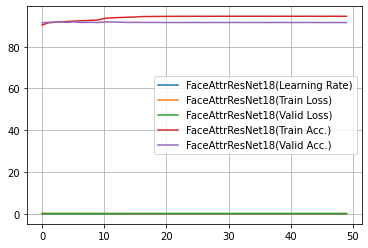

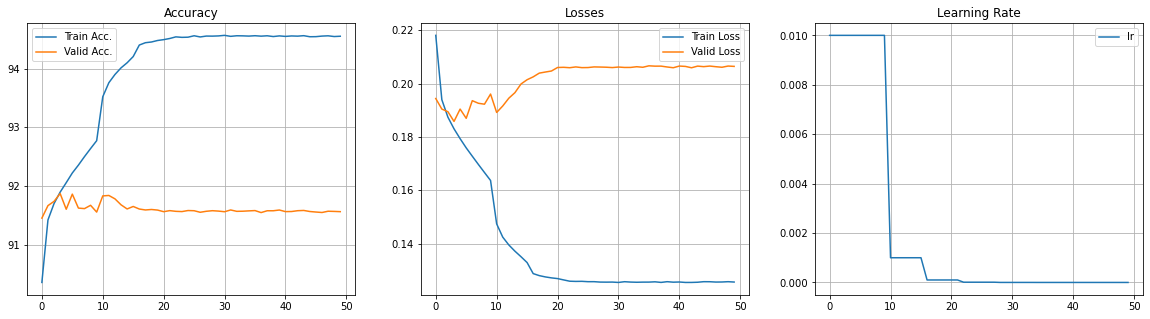

Best accuracy:
91.87018673975948
=> Model trained time: 05:32:14


<Figure size 432x288 with 0 Axes>

In [19]:
# config.epoch = 1
model = create_model(device)
dataloaders, attribute_names = load_dataloaders()
criterion = get_criterion()
optimizer = get_optimizer(model)

print(f"=> Training model: {not config.evaluate}")
if config.evaluate:
    best_prec1, mtimer, _, _, logger, = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.checkpoint_fname) # checkpoint_fname bestmodel_fname
    #logger.plot_special()
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)
else:
    best_prec1, mtimer, lr, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
    run_name, run_time = get_run_name_time(model, criterion, optimizer, comments)
    mtimer = trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name, mtimer)

print(f"=> Model trained time: {mtimer}")

## Testing Loop

In [20]:
if not config.evaluate:
    config.evaluate = True
    model = create_model(device)
    dataloaders, attribute_names = load_dataloaders()
    criterion = get_criterion()
    optimizer = get_optimizer(model)
    
    best_prec1, mtimer, _, _, _, = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)# config.bestmodel_fname  config.checkpoint_fname
    #print(model)
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print(f"=> Model trained time: {mtimer}")
    print_attribute_acc(top1, attribute_names)

=> creating model 'FaceAttrResNet'
Dataset sizes: {'test': 19962}
Class Labels: 40
=> resuming model: checkpoints\model_best.pth.tar
=> loading checkpoint 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\model_best.pth.tar' (epoch 4)
=> resuming logger
{'Learning Rate': ['0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.010000000000000', '0.001000000000000', '0.001000000000000', '0.001000000000000', '0.001000000000000', '0.001000000000000', '0.001000000000000', '0.000100000000000', '0.000100000000000', '0.000100000000000', '0.000100000000000', '0.000100000000000', '0.000100000000000', '0.000010000000000', '0.000010000000000', '0.000010000000000', '0.000010000000000', '0.000010000000000', '0.000010000000000', '0.000001000000000', '0.000001000000000', '0.000001000000000', '0.000001000000000', '0.000001000000000', '0.000001000000000', '0.000000100000000', '0.000000100000000', '0.000000100000000', '0.000000100000000', '0.000000100000000', '0.000000100000000', '0.000000010000000', '0.000000010000000', '0.0000000100000

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.32it/s]

(156/156) Data: 0.052s | Batch: 0.154s | Total: 0:00:24 | ETA: 0:00:01 | Loss: 0.1935 | top1:  91.3650
=> Best test accuracy: 91.36496842377365, Model val acc: 91.87018673975948
=> Model trained time: 00:25:39
5_o_Clock_Shadow: 93.84831177329578
Arched_Eyebrows: 84.21500851847392
Attractive: 82.65704839041591
Bags_Under_Eyes: 85.41729285260526
Bald: 99.13335337446324
Bangs: 95.88217610637335
Big_Lips: 71.80142269167008
Big_Nose: 84.42540824361942
Black_Hair: 89.57018334759749
Blond_Hair: 96.04749020315724
Blurry: 96.34305176401936
Brown_Hair: 88.57829875772146
Bushy_Eyebrows: 91.98978055788298
Chubby: 95.79701430811193
Double_Chin: 96.56347055667365
Eyeglasses: 99.71445746919146
Goatee: 97.7056406890805
Gray_Hair: 98.27672574458244
Heavy_Makeup: 91.54894297868954
High_Cheekbones: 87.62649033698084
Male: 98.25668771275775
Mouth_Slightly_Open: 94.04869248443991
Mustache: 97.02434626400513
Narrow_Eyes: 87.76675683417022
No_Beard: 96.3630898363568
Oval_Face: 75.61867545360721
Pale_Skin: 96

## Save & Backup

In [21]:
if ISJUPYTER:
    # Wait for notebook to save
    %autosave 1
    time.sleep(150)
    %autosave 120

Autosaving every 1 seconds


Autosaving every 120 seconds


In [22]:
def backup_everything(run_time, run_name, title, backup_nb=ISJUPYTER):
    # backup checkpoints
    print(f"=> backing up checkpoints... ")
    run_dir = os.path.join(config.BACKUP_DIR, run_name, run_time)
    create_dir_ifne(run_dir)
    fromDirectory = config.CHECKPOINT_DIR
    toDirectory = run_dir
    copy_tree(fromDirectory, toDirectory)
    
    if backup_nb:
        print(f"=> backing up notebook... ")
        # backup notebook html
        nb_name = title + '.ipynb'
        html_name = title + '.html'
        save_name = os.path.join(run_dir, html_name)
        !jupyter nbconvert --to html $nb_name
        shutil.move(html_name, save_name)
    
backup_everything(run_time, run_name, title, backup_nb=ISJUPYTER)

=> backing up checkpoints... 
=> backing up notebook... 


[NbConvertApp] Converting notebook ai6126-project1-colab-v1.1.ipynb to html
[NbConvertApp] Writing 688923 bytes to ai6126-project1-colab-v1.1.html


In [23]:
if config.auto_hibernate and False:
    os.system('shutdown -h')